### Hopefully building up a little library of things. Not really sure how well they work though...

In [22]:
import numpy as np
from sage.modules.misc import gram_schmidt

In [23]:
def uniform_rand_vec(dimension):
    """
    Makes a uniformly random vector.
    
    Args:
    - Desired dimension
    
    Returns:
    - Uniformly random vector of that dimension 
    """
    xs = np.random.normal(0,1,dimension) #normally random x's
    norm = sum(xs**2)**0.5 #and then normalize
    return vector(xs/norm)

#####################################################################################

def flat_vec(dim):
    """
    Makes a flat vector.
    
    Args:
    - Desired dimension
    
    Returns:
    - Vector of that dimension with entries of modulus 1
    """
    theta = np.random.uniform(0,2*pi,dim)    
    vec = []
    for j in range(dim):
        vec.append(math.sin(theta[j])+math.cos(theta[j])*I)

    return vec

In [24]:
def degen_find_min(G1):
    """
    Finds the degeneracy of a given graph by plucking off minimum degree vertices,
    and placing them at the end of the optimal ordering
    
    Args:
    - The graph
    
    Returns:
    - Degeneracy of the graph
    - Ordering of vertices that admits that degeneracy
    """
    ### Finding the optimal ordering ###
    G=G1.copy()
    n = len(G.vertices());
    ordering = [None for i in range(n)];
    j = 0; #counts how many vertices we've deleted so far

    while j < n:
        degs = G.degree(i for i in G.vertices()) #degrees of all vertices in graph
        mind = min(degs); #mininum degree
        for k in G.vertices():
            if G.degree(k) == mind:
                ordering[n-1-j] = k; #if the vertex has min degree, put it at end of ordering
                G.delete_vertex(k); #and remove that vertex from the graph
                j = j+1
                break
    
    ### Finding the degeneracy of that ordering###
    npnv=[] #empty list of the number of previous neighbors
    
    for i in range(n):
        vi = ordering[i] #the vertex associated with index i in the optimal ordering
        npn=0 #number of previous neighbors to vertex vi
        for j in range(i): #for all previous vertices in the optimal ordering
            vj = ordering[j]
            if vj in G1.neighbors(vi): #if the vertex is adjacent to vertex vi, increase the number of previous neighbors of i
                npn+=1
        npnv.append(npn) #put the number of vi's previous neighbors into the list of number of previous neighbors
    degen = max(npnv) #the degeneracy is the max of all of those previous neighbors
    
    return ordering,degen

#####################################################################################

def degen_find_max(G1):
    """
    Finds the degeneracy of a given graph by ordering the vertices from highest to lowest degree for the optimal ordering
    
    Args:
    - The graph
    
    Returns:
    - Degeneracy of the graph
    - Ordering of vertices that admits that degeneracy
    """
    
    ### Finding the optimal ordering ###
    G=G1.copy()
    n = len(G.vertices());
    ordering=[];
    j = 0; #counts how many vertices we've deleted so far
    degs = G.degree(i for i in G.vertices()) #degrees of all vertices in graph
    
    while j < n:
        maxd=max(degs)
        for k in G.vertices():
            if G1.degree(k) == maxd:
                ordering.append(k)
                degs.remove(maxd)
                G.delete_vertex(k)
                j=j+1
                break
            
    ### Finding the degeneracy of that ordering###
    npnv=[] #empty list of the number of previous neighbors
    for i in range(n):
        vi = ordering[i] #the vertex associated with index i in the optimal ordering
        npn=0 #number of previous neighbors to vertex vi
        for j in range(i): #for all previous vertices in the optimal ordering
            vj = ordering[j]
            if vj in G1.neighbors(vi): #if the vertex is adjacent to vertex vi, increase the number of previous neighbors of i
                npn+=1
        npnv.append(npn) #put the number of vi's previous neighbors into the list of number of previous neighbors
    degen = max(npnv) #the degeneracy is the max of all of those previous neighbors

    return ordering,degen

#####################################################################################
#####################################################################################

def modified_LSS(G,Vorder,d):
    """
    Finds an orthogonal representation of the graph
    
    Args:
    - The graph
    - An ordering of the vertices
    - Desired dimension of the orthogonal representation
    
    Returns:
    - An orthogonal representation of the graph
    """
    
    n = len(Vorder) #number of vertices
    us = [None for i in range(n)] #empty list in which we can put uniformly random vectors
    fs=[] #empty list into which we shall put orthogonal vectors

    for i in range(n): # assign uniformly random vectors to everything
        us[i] = vector(uniform_rand_vec(d)) 
        
    fs.append(Matrix(us[0])); #first one is just the regular random guy
 
    for i in range(1,n):
        prev_f = []; #gather the previously assigned f vectors (the orthogonal ones)
        vi = Vorder[i]; #the vertex in the ith place
        
        nnp=0; #number of neighbors previous in the list
        for j in range(i): #for all the vertices previous in the listed order
            vj = Vorder[j]; #the vertex in the jth place
            
            if vj in G.neighbors(vi): #if the previous vertex is a neighbor of this one
                nnp+=1; #add one to the count of previous neighbors
                prev_f.append(vector(fs[j])) #collect its vector in the list of previous f vectors
                bassisor,b = Matrix(prev_f).gram_schmidt() #gram schmidtify the previous f vectors into an orthogonal basis
        
        newv = Matrix(us[i]) #the new vector will be the randomly generated u and then we'll mess with it
        if nnp != 0: #if there were neighbors previous in the list
    
            for v1 in bassisor: #for all vectors in that basis of prev fs
                v1vec=Matrix(v1); #make a matrix out of it
                newv -= Matrix((newv*v1vec.T)*v1vec) #subtract the projection of u onto that vec from u
            
        fs.append(newv) #normalize and add it to the list of f vectors
    return fs

#####################################################################################



In [25]:
def quat_tophats(vec):
    """
    Makes the four tophat vectors for quaternion construction from one 4D vector
    
    Args:
    - A 4D vector
    
    Returns:
    - A list of four orthogonal projectors
    """
    
    phi0 = Matrix(vec[0])
    phi1 = Matrix([-vec[0][1],vec[0][0],-vec[0][3],vec[0][2]])
    phi2 = Matrix([-vec[0][2],vec[0][3],vec[0][0],-vec[0][1]])
    phi3 = Matrix([-vec[0][3],-vec[0][2],vec[0][1],vec[0][0]])

    #now outerproduct dotify them to make projection matrices
    proj0 = phi0.T * phi0
    proj1 = phi1.T * phi1
    proj2 = phi2.T * phi2
    proj3 = phi3.T * phi3
    
    return proj0, proj1, proj2, proj3 #tadah
    
#####################################################################################

def quat_const(vecs):
    """
    Constructs quantum coloring using quaternion construction
    
    Args:
    - List of 4D vectors in a real orthogonal representation
    
    Returns:
    - A quantum 4-coloring
    """
    
    n = len(vecs)
    qch = [];
    
    for j in range(n):
        qch.append(quat_tophats(vecs[j]/vecs[j].norm()))
    return qch
        
#####################################################################################
    
def oct_tophats(vec):
    """
    Makes the eight tophat vectors for octonion construction from one 8D vector
    
    Args:
    - An 8D vector
    
    Returns:
    - A list of eight orthogonal projectors
    """
        
    tophat=[None for i in range(8)];
    tophat[0] = Matrix([ vec[0][0],  vec[0][1],  vec[0][2],  vec[0][3],  vec[0][4],  vec[0][5],  vec[0][6],  vec[0][7] ])
    tophat[1] = Matrix([-vec[0][1],  vec[0][0], -vec[0][3],  vec[0][2], -vec[0][5],  vec[0][4],  vec[0][7], -vec[0][6] ])
    tophat[2] = Matrix([-vec[0][2],  vec[0][3],  vec[0][0], -vec[0][1], -vec[0][6], -vec[0][7],  vec[0][4],  vec[0][5] ])
    tophat[3] = Matrix([-vec[0][3], -vec[0][2],  vec[0][1],  vec[0][0], -vec[0][7],  vec[0][6], -vec[0][5],  vec[0][4] ])
    tophat[4] = Matrix([-vec[0][4],  vec[0][5],  vec[0][6],  vec[0][7],  vec[0][0], -vec[0][1], -vec[0][2], -vec[0][3] ])
    tophat[5] = Matrix([-vec[0][5], -vec[0][4],  vec[0][7], -vec[0][6],  vec[0][1],  vec[0][0],  vec[0][3], -vec[0][2] ])
    tophat[6] = Matrix([-vec[0][6], -vec[0][7], -vec[0][4],  vec[0][5],  vec[0][2], -vec[0][3],  vec[0][0],  vec[0][1] ])
    tophat[7] = Matrix([-vec[0][7],  vec[0][6], -vec[0][5], -vec[0][4],  vec[0][3],  vec[0][2], -vec[0][1],  vec[0][0] ])
    
    cowboy=[];
    for i in range(8):
        cowboy.append(tophat[i].conjugate_transpose() * tophat[i])
    
    return cowboy

#####################################################################################
def oct_const(vecs):
    """
    Constructs quantum coloring using octonion construction
    
    Args:
    - List of 8D vectors in a real orthogonal representation
    
    Returns:
    - A quantum 8-coloring
    """
        
    n=len(vecs)
    qch = [];
    for j in range(n):
         qch.append(oct_tophats(vecs[j]/vecs[j].norm()))
    return qch
    

In [26]:
def reconstructing(vecs,ordering):
    """
    Reconstructs a graph from vector adjacencies
    
    Args:
    - List of vectors
    
    Returns:
    - A graph with as many vertices as there are vectors, where vertices are adjacent if vectors are orthogonal
    """
    
    n = len(vecs) #how many vectors we have
    G_r = Graph() #empty graph
    G_r.add_vertices([i for i in range(n)]) #add vertices to the empty graph
    for i in range(n): #for all vertices
        for j in range(i+1,n):
            b=Matrix(vecs[i])*Matrix(vecs[j]).T #find the dot product of the vectors in the orthogonal representation
            if abs(b[0])<1e-9: #if that's about zero
                vi=ordering[i]; #name vi and vj as the ones in the order
                vj=ordering[j];
                G_r.add_edge([vi,vj]) #add an edge between vi and vj
    return G_r

#####################################################################################

#putting together:

def degen_OR_recon(G):
    """
    Finds degeneracy of graph and optimal vertex-ordering, constructs orthogonal representation, and reconstructs the graph
    
    Args:
    - The graph
    
    Returns:
    - A graph reconstructed from vector adjacencies
    """
    
    [ordering, degen] = degen_find_max(G)
    vecs = modified_LSS(G,ordering,degen+1)
    G_r = reconstructing(vecs,ordering)
    
    return G_r


In [27]:
def check_qch(qch,G,ordering):
    """
    Checks whether or not it's actually a quantum coloring
    
    Args:
    - Purported quantum coloring
    - The graph
    
    Returns:
    - IF FAILED, returns errors
    """
    
    n = len(qch);
    c = len(qch[0])
    d = len(qch[0][0][0])
    
    comp_errs = 0; #initialize number of completeness errors
    orth_errs = 0; #initialize number of orthogonality errors
    #checking completeness
    for vi in range(n):
        summ = sum(qch[vi]) #sum them all up
        for i in range(d):
            for j in range(d):
                if ((i == j) and (abs(summ[i,j]) >= 1+1e-5)) or ((i != j) and (abs(summ[i][j] > 1e-5))):
                    print('Failure on vertex ', G.vertices()[vi]) #if ON diagonal and NOT ~1, or OFF diagonal and NOT ~0, print where it failed
                    comp_errs +=1;

    #checking orthogonality
    #if they're different vertices and their respective qch matrices multiply to have trace not ~0, and they're adjacent
    #then print where they failed
    for i in range(n):
        vi = ordering[i]
        for j in range(i):
            vj = ordering[j];
            for ci in range(c):
                #if the vertices are different AND the trace of their product isn't zero AND they're neighbors, then it's failure
                #if ((vi != vj) and (abs((qch[vi][ci]*qch[vj][ci].conjugate_transpose()).trace()) > 1e-5) and (G.vertices()[vi] in G.neighbors(G.vertices()[vj]))):
                #if (  abs( (qch[i][ci]*qch[j][ci].conjugate_transpose() ).trace() ) > 1e-5  ) and ( vi in G.neighbors(vj)):
                vjMAT = qch[j][ci]
                viMAT = qch[i][ci]
                thetrace = (vjMAT*viMAT).trace()
                if (vi in G.neighbors(vj)) and (abs(thetrace) > 1e-5) :
                    print('Failure on vertices ', G.vertices()[vi], G.vertices()[vj],' on color ',ci)
                    print('With trace of ', thetrace)
                    #print('With trace of ',((qch[vi][ci]*qch[vj][ci].conjugate_transpose()).trace()))
                    #print('And matrices of ',((qch[vi][ci]*qch[vj][ci].conjugate_transpose())))
                    orth_errs +=1;
    
    if ((comp_errs == 0) and (orth_errs == 0)):
        print('All quiet on the errors front')
    else:
        print('Wow, whoops!\nCompleteness errors:', comp_errs,'\nOrthogonality errors: ',orth_errs)

    return


In [28]:
def halve_qcoloring(qch):
    """
    Cuts an 8D quantum 8-coloring down into being a 4D quantum 8-coloring

    Args:
    - An 8D quantum 8-coloring

    Returns:
    - A 4D quantum 8-coloring
    """
    
    n = len(qch);
    c = len(qch[0]);
    dhalf = len(qch[0][0][0])/2;
    hqch = [] #empty list for when we halve it
    
    for vi in range(n):
        listofmats = []; #empty list of halved matrices for this vertex
        for ci in range(c):
            #ignore the fact that I don't know how to use Sage and thus had to make a silly ass matrix
            #empt = Matrix([math.pi, math.pi, math.pi, math.pi]).T*Matrix([math.pi, math.pi, math.pi, math.pi])
            empt = Matrix(QQ,dhalf,dhalf,range(dhalf*dhalf))
            for i in range(dhalf):
                for j in range(dhalf):
                    empt[i,j] = qch[vi][ci][i][j]
            listofmats.append(empt)
        hqch.append(listofmats)

    return hqch


        

All quiet on the errors front


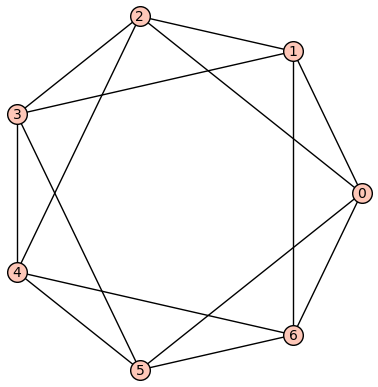

In [562]:
#Example of constructing Circulant Graph on 7 vertices with flat orthogonal representation
G = graphs.CirculantGraph(7,[1,2])

vecs = [None for i in range(7)]
vecs[0] = Matrix([-1, -1,  1, -1])
vecs[1] = Matrix([-1, -1, -1,  1])
vecs[2] = Matrix([-1,  1, -1, -1])
vecs[3] = Matrix([ 1, -1, -1, -1])
vecs[4] = Matrix([-1, -1, -1,  1])
vecs[5] = Matrix([-1,  1, -1, -1])
vecs[6] = Matrix([ 1, -1, -1, -1])
quat_const(vecs)
check_qch(quat_const(vecs),G,G.vertices())
G.show()




All quiet on the errors front


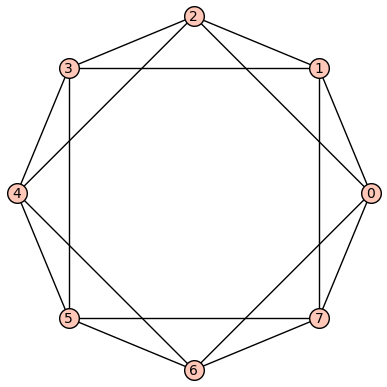

In [571]:
#Example of constructing Circulant Graph on 8 vertices with flat orthogonal representation
G = graphs.CirculantGraph(8,[1,2])

vecs = [None for i in range(8)]
vecs[0] = Matrix([ 1,  1,  1, -1])
vecs[1] = Matrix([-1,  1,  1,  1])
vecs[2] = Matrix([ 1,  1, -1,  1])
vecs[3] = Matrix([ 1, -1,  1,  1])
vecs[4] = Matrix([ 1,  1,  1, -1])
vecs[5] = Matrix([-1,  1,  1,  1])
vecs[6] = Matrix([ 1,  1, -1,  1])
vecs[7] = Matrix([ 1, -1,  1,  1])
quat_const(vecs)
check_qch(quat_const(vecs),G,G.vertices())
G.show()




In [192]:
from random import randrange

In [ ]:
## This is me trying to brute force something with a (random) 4d orthogonal representation that, when reconstructed, gives
# a graph with chromatic number greater than or equal to five. Yeah it's stupid. I know.

def pull_shit_from_nothing(n,d):
    pm = [-1,0,1]
    vecs = [None for i in range(n)]
    for i in range(n):
        vecs[i] = Matrix([pm[randrange(0,3)] for j in range(d)])
    G_r = reconstructing(vecs, [i for i in range(n)])
    return G_r, vecs

def more_shit_pulling(it,n,d):
    pm = [-1,1]
    Gs = []
    vecs = []
    for i in range(it):
        #vecs = [None for i in range(n)]
        #for i in range(n):
        #    vecs[i] = Matrix([pm[randrange(0,2)] for j in range(d)])
        #G_r = reconstructing(vecs, [i for i in range(n)])
        [G_r,vecs_r] = pull_shit_from_nothing(n,d)
        ind = 1;
        for j in range(n):
            if abs(vecs_r[j].norm()) <= 1e-5:
                ind = 0;
        if (G_r.is_connected() == 1) and (G_r.chromatic_number() >= 4) and (ind == 1):
            print('ye')
            Gs.append(G_r)
            vecs.append(vecs_r)

    return Gs, vecs
[Gs, vecs] =more_shit_pulling(40,13,4)
Gs

ye
ye
ye
ye
ye


[Graph on 13 vertices,
 Graph on 13 vertices,
 Graph on 13 vertices,
 Graph on 13 vertices,
 Graph on 13 vertices]

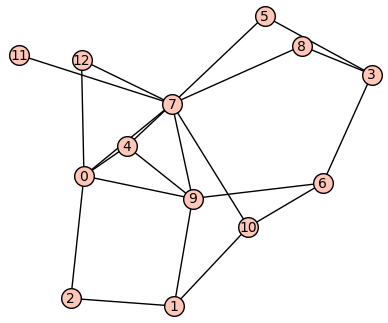

[[ 0 -1 -1  0],
 [1 1 0 0],
 [ 0  0  0 -1],
 [0 1 1 1],
 [ 1  1 -1 -1],
 [ 1  0  1 -1],
 [ 0 -1  0  1],
 [1 0 0 1],
 [ 1  1  0 -1],
 [ 1 -1  1 -1],
 [-1  1  1  1],
 [-1  0  1  1],
 [ 1  0  0 -1]]

In [542]:
Gs[0].show()
vecs[0]

4


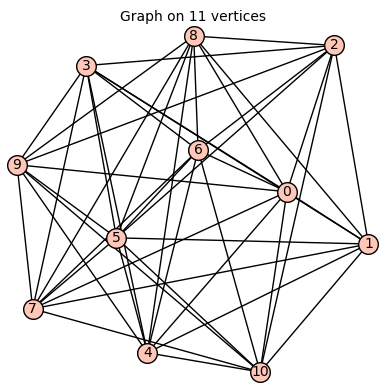

In [560]:

vecs = [None for i in range(11)]
vecs[0]  = Matrix([-1, -1, -1, -1])
vecs[1]  = Matrix([-1, -1,  1,  1])
vecs[2]  = Matrix([ 1, -1,  1, -1])
vecs[3]  = Matrix([-1,  1,  1, -1])
vecs[4]  = Matrix([ 1, -1,  1, -1])
vecs[5]  = Matrix([ 1,  1,  1,  1])
vecs[6]  = Matrix([-1, -1,  1,  1])
vecs[7]  = Matrix([ 1, -1,  1, -1])
vecs[8]  = Matrix([ 1, -1, -1,  1])
vecs[9]  = Matrix([ 1,  1, -1, -1])
vecs[10] = Matrix([ 1, -1, -1,  1])
G_r=reconstructing(vecs, [i for i in range(11)])
print(G_r.chromatic_number())
G_r

4


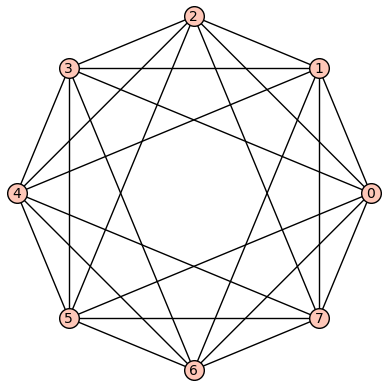

In [569]:
G=graphs.CirculantGraph(8,[1,2,3])
#G=graphs.HammingGraph(2,5)
#G=graphs.KneserGraph(9,2)
print(G.chromatic_number())
G.show()
#len(G.vertices())
#graphs.PetersenGraph().chromatic_number()


In [29]:
G= Graph() #define a graph
G.add_vertices([i for i in range(6)]) #add 6 vertices
G.add_edges([(0,1),(0,2),(0,3),(0,4),(3,4),(2,5)]) #add edges
[ordering, degen] = degen_find_max(G)
vecs=modified_LSS(G,ordering,8)
reconstructing(vecs,ordering)

qch=oct_const(vecs)
check_qch(qch,G,ordering)

#(qch[3][3].conjugate_transpose()).trace()
print(ordering)
#G.show()
qch[1][0]*qch[5][0].T
ordering[1] in G.neighbors(ordering[5])
hqch=halve_qcoloring(qch)
#check_qch(hqch,G,ordering)

All quiet on the errors front
[0, 2, 3, 4, 1, 5]


In [30]:
#make graph from "On the quantum chromatic number of a graph"
G = Graph()
G.add_edges([(1,2),(1,3), (1,11), (1,12), (1,16), (2,3), (2,4), ( 2,13), ( 3, 4) ,(3,13), (4,5), (4,6), (4,10), (4,17)])
G.add_edges([(5,6), (5,7), (5,14), (6, 7), (6,14), (7,8), (7,9), (7,16), (8,9), (8,10), (8,13), (9,10), (9,13), (10,11)])
G.add_edges([(10, 12), (10,17), (11,12), (11,14), (12,14), (13,14), (13,15), (13,18), (14,15), (14,18), (15,16), (15,17)])
G.add_edges([(15,18), (16,17), (16,18), (17,18)])

# assign vectors to those vertices as given in the paper
vecss=[None for i in range(18)]
vecss[0]=Matrix([0,0,1,-1])
vecss[1]=Matrix([1,0,0,0])
vecss[2]=Matrix([0,1,1,1])
vecss[3]=Matrix([0,1,0,-1])
vecss[4]=Matrix([0,0,1,0])
vecss[5]=Matrix([1,1,0,1])
vecss[6]=Matrix([1,-1,0,0])
vecss[7]=Matrix([0,0,0,1])
vecss[8]=Matrix([1,1,1,0])
vecss[9]=Matrix([1,0,-1,0])
vecss[10]=Matrix([0,1,0,0])
vecss[11]=Matrix([1,0,1,1])
vecss[12]=Matrix([0,1,-1,0])
vecss[13]=Matrix([1,0,0,-1])
vecss[14]=Matrix([1,1,1,1])
vecss[15]=Matrix([1,1,-1,-1])
vecss[16]=Matrix([1,-1,1,-1])
vecss[17]=Matrix([1,-1,-1,1])

# G.show()


#G_const = Graph() #make a graph whose adjacencies are decided by orthogonality
#G_const.add_vertices([i+1 for i in range(18)])
#for i in range(18):
    #for j in range(18):
        #if abs((vecss[i]*vecss[j].transpose())[0]) <= 1e-2:
##             print(i,j)
            #G_const.add_edge([i+1,j+1])

    
#G_const.show()
# Gcons = Graph()
# Gcons.add_vertices([i+1 for i in range(18)])
# for i in range(18):
#     for j in range(i+1,18):
#         b=Matrix(vecss[i])*Matrix(vecss[j]).T

#         if abs(b[0])<1e-5:

#             Gcons.add_edge([i+1,j+1])

# Gcons.show()
# G.show()
# Gcons.size()
# G.is_subgraph(Gcons)
# vecss[0]*vecss[1].transpose() <=e-2

#make a quantum coloring from those vectors using the quaternion construction
qqs = [None]*len(vecss)
for j in range(len(vecss)):
    qqs[j]=(vecss[j]/vecss[j].norm())
    
qqs0=quat_const(qqs)

# for i in range(1):
#for j in range(4):
    #print(qqs[1][j])
# qqs[0][0]


cn=Matrix([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]]) #make the cnot matrix
vecss1=[None]*18 #empty vector
for i in range(18): #multiply all the vectors by the cnot
    vecss1[i] = (cn*vecss[i].transpose()).transpose()
    
qqs1 = [None]*len(vecss); #use the quaternion method on the new cnot'd vectors
for j in range(len(vecss)):
    qqs1[j]=(vecss1[j]/vecss1[j].norm())

qqs1=quat_const(vecss1)

# for i in range(18): #check for completeness
#     print(qqs1[i][0]+qqs1[i][1]+qqs1[i][2]+qqs1[i][3])

# print(qqs[1][2],'\n',qqs1[1][2])
#qqs[1][2] == qqs1[1][2]
#for i in range(18):
    #for j in range(4):
        #if abs((qqs[i][j] - qqs1[i][j]).trace()) <=e-4:
            #print('na')
#         print(qqs[i][j] == qqs1[i][j])
#print(qqs[4][3]-qqs1[4][3])
#print('\n')
#print(qqs[4][3])

In [31]:
check_qch(qqs1,G,G.vertices())
check_qch(qqs0,G,G.vertices())

All quiet on the errors front
All quiet on the errors front


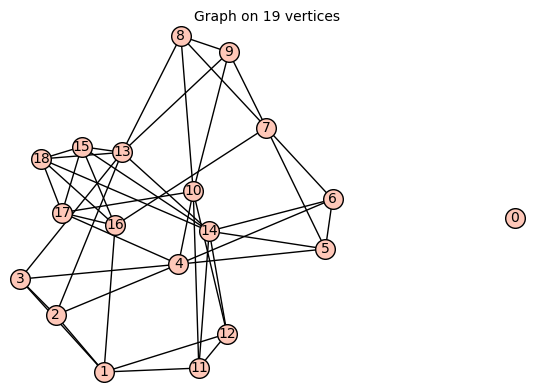

In [32]:
[ordering,k]=degen_find_max(G)
vecs=modified_LSS(G,ordering,k+1)
reconstructing(vecs,ordering)

In [33]:
hqch = halve_qcoloring(qch)
#qch[0][0][0][0]
hqch
#qch
#check_qch(hqch,G)

#len(hqch[0][0][0])

check_qch(halve_qcoloring(halve_qcoloring(hqch)),G)
bees=halve_qcoloring(halve_qcoloring(hqch))
#float(bees[0][0][0][0])

float(((bees[0][0]*bees[1][0].conjugate_transpose())).trace())


TypeError: check_qch() missing 1 required positional argument: 'ordering'

In [ ]:
G = graphs.CirculantGraph(7,[1,2])
# G_r=degen_OR_recon(G)
# G.is_isomorphic(G_r)
[ordering, degen] = degen_find_max(G)
vecs=modified_LSS(G,ordering,8)
# oct_tophats(vecs)
oct_tophats(vecs[0])

[
[   0.42058702528158487    0.01599157144786023    0.20304804579535637   -0.19180132830123836  -0.060883017096617704    -0.2850989584139372     0.1770020899331534    -0.2215935309285106]  [0.0006080319696044024  -0.01599157144786023 -0.007292675382152465 -0.007720298384171311 -0.010840040441415467 0.0023148957512657896  0.008425435330189818  0.006729978333714752]  [  0.09802610737625696    0.0925964962101393  -0.20304804579535637  0.007720298384171311    0.0854518240037452     -0.10697936624603   0.02939267476289114   0.13763806985126256]  [   0.08746762816444437    -0.0925964962101393   0.007292675382152465    0.19180132830123836    0.10105383908739138    0.08071869534859025    0.13001437427719648   -0.02776463097571824]  [  0.008813257537617487  -0.041270138439773764    0.02562233407062993   -0.03207726801127049   0.060883017096617704 -0.0023148957512657896   -0.02939267476289114    0.02776463097571824]  [   0.1932570697688394  0.041270138439773764  -0.15020930523638545  -0.11998256

In [ ]:
var('a1 a2 a3 a4')
var('b1 b2 b3 b4')
var('c1 c2 c3 c4')
var('d1 d2 d3 d4')
var('e1 e2 e3 e4')
var('f1 f2 f3 f4')
var('g1 g2 g3 g4')

M = Matrix([[a1 , b1, c1, d1, e1, f1, g1],
        [a2 , b2, c2, d2, e2, f2, g2],
        [a3 , b3, c3, d3, e3, f3, g3],
        [a4 , b4, c4, d4, e4, f4, g4]])

mtm = M.transpose() * M
mmt = M * M.transpose()


In [ ]:
mmt.charpoly()

x^4 + (-a1^2 - a2^2 - a3^2 - a4^2 - b1^2 - b2^2 - b3^2 - b4^2 - c1^2 - c2^2 - c3^2 - c4^2 - d1^2 - d2^2 - d3^2 - d4^2 - e1^2 - e2^2 - e3^2 - e4^2 - f1^2 - f2^2 - f3^2 - f4^2 - g1^2 - g2^2 - g3^2 - g4^2)*x^3 + (a2^2*b1^2 + a3^2*b1^2 + a4^2*b1^2 - 2*a1*a2*b1*b2 + a1^2*b2^2 + a3^2*b2^2 + a4^2*b2^2 - 2*a1*a3*b1*b3 - 2*a2*a3*b2*b3 + a1^2*b3^2 + a2^2*b3^2 + a4^2*b3^2 - 2*a1*a4*b1*b4 - 2*a2*a4*b2*b4 - 2*a3*a4*b3*b4 + a1^2*b4^2 + a2^2*b4^2 + a3^2*b4^2 + a2^2*c1^2 + a3^2*c1^2 + a4^2*c1^2 + b2^2*c1^2 + b3^2*c1^2 + b4^2*c1^2 - 2*a1*a2*c1*c2 - 2*b1*b2*c1*c2 + a1^2*c2^2 + a3^2*c2^2 + a4^2*c2^2 + b1^2*c2^2 + b3^2*c2^2 + b4^2*c2^2 - 2*a1*a3*c1*c3 - 2*b1*b3*c1*c3 - 2*a2*a3*c2*c3 - 2*b2*b3*c2*c3 + a1^2*c3^2 + a2^2*c3^2 + a4^2*c3^2 + b1^2*c3^2 + b2^2*c3^2 + b4^2*c3^2 - 2*a1*a4*c1*c4 - 2*b1*b4*c1*c4 - 2*a2*a4*c2*c4 - 2*b2*b4*c2*c4 - 2*a3*a4*c3*c4 - 2*b3*b4*c3*c4 + a1^2*c4^2 + a2^2*c4^2 + a3^2*c4^2 + b1^2*c4^2 + b2^2*c4^2 + b3^2*c4^2 + a2^2*d1^2 + a3^2*d1^2 + a4^2*d1^2 + b2^2*d1^2 + b3^2*d1^2 + b4^2*d1^2 